In [230]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pmdarima

gdp = pd.read_csv('../data/mexico_fred/gdp.csv')
consumption = pd.read_csv('../data/mexico_fred/consumption.csv')
investment = pd.read_csv('../data/mexico_fred/investment.csv')
exports = pd.read_csv('../data/mexico_fred/exports.csv')
imports = pd.read_csv('../data/mexico_fred/imports.csv')

In [231]:
gdp

,DATE,NAEXKP01MXQ661S
0,1980-01-01,44.719784
1,1980-04-01,45.011521
2,1980-07-01,45.983214
3,1980-10-01,47.314826
4,1981-01-01,48.371353
...,...,...
170,2022-07-01,106.687860
171,2022-10-01,107.410851
172,2023-01-01,108.023425
173,2023-04-01,109.033048


In [232]:
consumption

,DATE,NAEXKP02MXQ661S
0,1980-01-01,44.230194
1,1980-04-01,45.002112
2,1980-07-01,46.101335
3,1980-10-01,47.231852
4,1981-01-01,47.583991
...,...,...
170,2022-07-01,108.654832
171,2022-10-01,108.905646
172,2023-01-01,111.293218
173,2023-04-01,112.051408


In [233]:
investment

,DATE,NAEXKP04MXQ661S
0,1980-01-01,44.037200
1,1980-04-01,44.998154
2,1980-07-01,46.487005
3,1980-10-01,46.967455
4,1981-01-01,51.149558
...,...,...
170,2022-07-01,92.988415
171,2022-10-01,97.579086
172,2023-01-01,104.559448
173,2023-04-01,111.783238


In [234]:
exports

,DATE,NAEXKP06MXQ661S
0,1980-01-01,7.015216
1,1980-04-01,7.229705
2,1980-07-01,7.382709
3,1980-10-01,7.701244
4,1981-01-01,8.241808
...,...,...
170,2022-07-01,128.301307
171,2022-10-01,121.720476
172,2023-01-01,121.119517
173,2023-04-01,117.362783


In [235]:
imports

,DATE,NAEXKP07MXQ661S
0,1980-01-01,13.682008
1,1980-04-01,14.104567
2,1980-07-01,14.555336
3,1980-10-01,13.948098
4,1981-01-01,18.882808
...,...,...
170,2022-07-01,127.683237
171,2022-10-01,125.795541
172,2023-01-01,132.146848
173,2023-04-01,133.079054


In [236]:
gdp.columns           = ['date', 'GDP']
consumption.columns   = ['date', 'C']
investment.columns    = ['date', 'I']
exports.columns       = ['date', 'X']
imports.columns       = ['date', 'M']

In [237]:
df = (
    gdp.merge(consumption, on='date')
    .merge(investment, on='date')
    .merge(exports, on='date')
    .merge(imports, on='date')
)
df['date'] = pd.to_datetime(df['date'])

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    175 non-null    datetime64[ns]
 1   GDP     175 non-null    float64       
 2   C       175 non-null    float64       
 3   I       175 non-null    float64       
 4   X       175 non-null    float64       
 5   M       175 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 8.3 KB


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

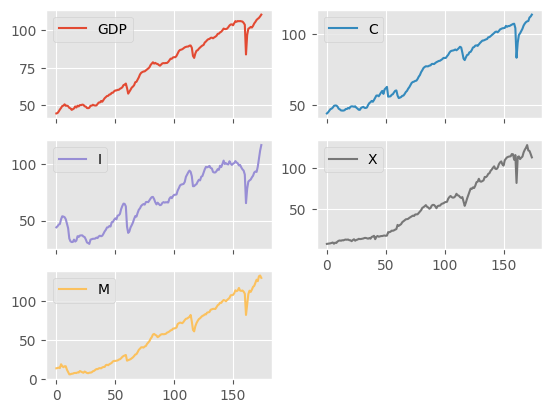

In [239]:
df[['GDP', 'C', 'I', 'X', 'M']].plot(subplots=True, layout=(3,2))

In [240]:
tolog = ['GDP', 'C', 'I', 'X', 'M']
for var in tolog:
    df[var] = np.log(df[var])

df = df.set_index('date')
# normalize by 1990 period
for var in ['GDP', 'C', 'I', 'X', 'M']:
    df[var] = 100 * df[var] / df[var][pd.to_datetime('1990')]
df = df.reset_index()

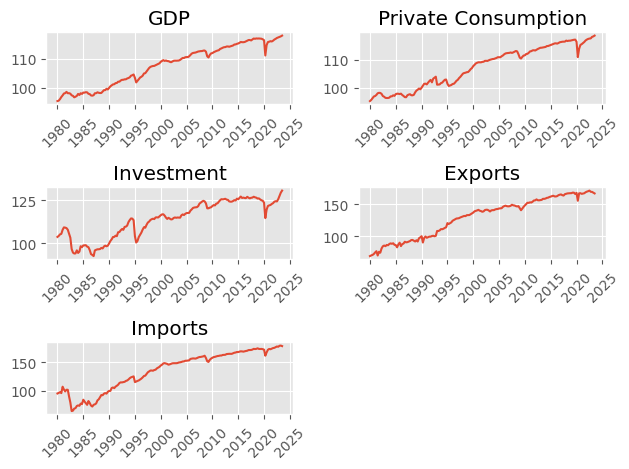

In [241]:
plt.subplot(321)
plt.plot(df['date'], df['GDP'])
plt.xticks(rotation=45)
plt.title('GDP')

plt.subplot(322)
plt.plot(df['date'], df['C'])
plt.xticks(rotation=45)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df['date'], df['I'])
plt.xticks(rotation=45)
plt.title('Investment')

plt.subplot(324)
plt.plot(df['date'], df['X'])
plt.xticks(rotation=45)
plt.title('Exports')

plt.subplot(325)
plt.plot(df['date'], df['M'])
plt.xticks(rotation=45)
plt.title('Imports')

plt.tight_layout()

In [242]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def min_max_estimator(df, y, startdate_range, enddate):
    predictions = pd.DataFrame()
    for startdate in startdate_range:
        df_train = df[(df.date >= startdate) & (df.date <= enddate)]
        df_train['index'] = df_train.index
        model = smf.ols(formula = y + ' ~ index', data=df_train)    
        fit = model.fit()
        predictions[startdate] = fit.predict(df)
    min = predictions.min(axis=1)
    max = predictions.max(axis=1)
    return min, max

def get_pred_conf(arima, nperiods):
    prediction, conf = arima.predict(nperiods, return_conf_int=True, alpha=0.40)
    confidence_interval = pd.DataFrame(index=prediction.index)
    confidence_interval['lower'] = conf[:, 0]
    confidence_interval['upper'] = conf[:, 1]
    return prediction, confidence_interval

In [243]:
forecast = {
    'color':'blue',
    'alpha':0.25
}

df['index'] = df.index

# Mexican Peso Crisis

In [244]:
startdate_range = pd.date_range(pd.to_datetime('1980Q1'), pd.to_datetime('1989Q4'), freq='Q')
enddate = pd.to_datetime('1992Q4')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

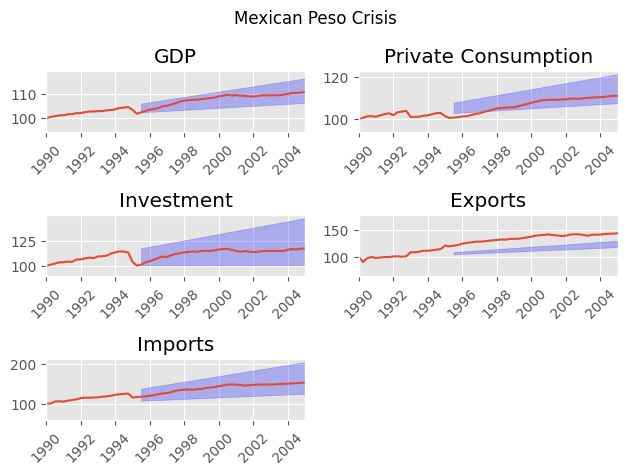

In [245]:
xmin = pd.to_datetime('1990')
xmax = pd.to_datetime('2005')
crisis = pd.to_datetime('1995Q2')

post = (df['date'] > crisis) & (df['date'] <= xmax)

plt.suptitle('Mexican Peso Crisis')

plt.subplot(321)
plt.plot(df.date, df['GDP'])
plt.fill_between(df.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')

plt.subplot(322)
plt.plot(df.date, df['C'])
plt.fill_between(df.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df.date, df['I'])
plt.fill_between(df.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(df.date, df['X'])
plt.fill_between(df.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(df.date, df['M'])
plt.fill_between(df.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

# Global Financial Crisis

In [246]:
startdate_range = pd.date_range(pd.to_datetime('1995Q1'), pd.to_datetime('2005Q1'), freq='Q')
enddate = pd.to_datetime('2007Q4')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

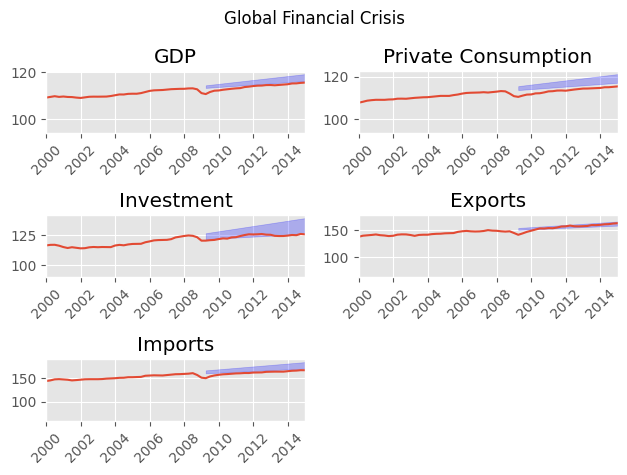

In [247]:
xmin = pd.to_datetime('2000')
xmax = pd.to_datetime('2015')
crisis = pd.to_datetime('2009Q1')

post = (df['date'] > crisis) & (df['date'] <= xmax)

plt.suptitle('Global Financial Crisis')

plt.subplot(321)
plt.plot(df.date, df['GDP'])
plt.fill_between(df.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')

plt.subplot(322)
plt.plot(df.date, df['C'])
plt.fill_between(df.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df.date, df['I'])
plt.fill_between(df.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(df.date, df['X'])
plt.fill_between(df.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(df.date, df['M'])
plt.fill_between(df.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

In [248]:
import pmdarima as pm

enddate = pd.to_datetime('2007Q4')
train = df.query('date <= @enddate')

arima = {}
pred = {}
conf_int = {}

arima['GDP'] = pm.auto_arima(train['GDP'], start_p=1, start_q=1, seasonal=False)
arima['C'] = pm.auto_arima(train['C'], start_p=1, start_q=1, seasonal=False)
arima['I'] = pm.auto_arima(train['I'], start_p=1, start_q=1, seasonal=False)
arima['X'] = pm.auto_arima(train['X'], start_p=1, start_q=1, seasonal=False)
arima['M'] = pm.auto_arima(train['M'], start_p=1, start_q=1, seasonal=False)

pred['GDP'], conf_int['GDP'] = get_pred_conf(arima['GDP'], 40)
pred['C'], conf_int['C'] = get_pred_conf(arima['C'], 40)
pred['I'], conf_int['I'] = get_pred_conf(arima['I'], 40)
pred['X'], conf_int['X'] = get_pred_conf(arima['X'], 40)
pred['M'], conf_int['M'] = get_pred_conf(arima['M'], 40)

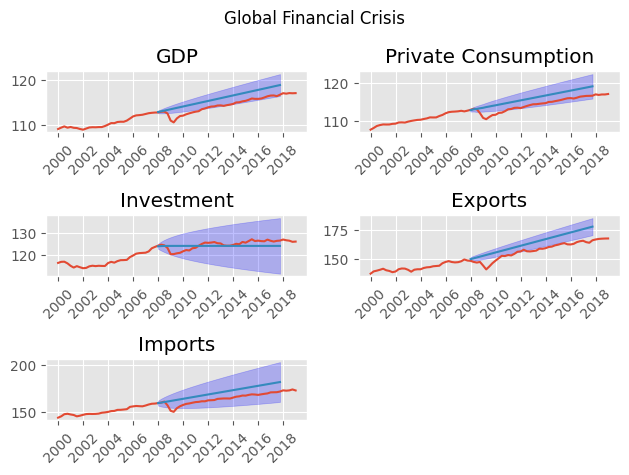

In [249]:
xrotation = 45
focus = df.query('date >= 2000').query('date <= 2019')

plt.suptitle('Global Financial Crisis')

plt.subplot(321)
plt.title('GDP')
plt.plot(focus.date, focus['GDP'])
plt.plot(focus.date[pred['GDP'].index], pred['GDP'])
plt.fill_between(focus.date[conf_int['GDP'].index], conf_int['GDP'].lower, conf_int['GDP'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(322)
plt.title('Private Consumption')
plt.plot(focus.date, focus['C'])
plt.plot(focus.date[pred['C'].index], pred['C'])
plt.fill_between(focus.date[conf_int['C'].index], conf_int['C'].lower, conf_int['C'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(323)
plt.title('Investment')
plt.plot(focus.date, focus['I'])
plt.plot(focus.date[pred['I'].index], pred['I'])
plt.fill_between(focus.date[conf_int['I'].index], conf_int['I'].lower, conf_int['I'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(324)
plt.title('Exports')
plt.plot(focus.date, focus['X'])
plt.plot(focus.date[pred['X'].index], pred['X'])
plt.fill_between(focus.date[conf_int['X'].index], conf_int['X'].lower, conf_int['X'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(325)
plt.title('Imports')
plt.plot(focus.date, focus['M'])
plt.plot(focus.date[pred['M'].index], pred['M'])
plt.fill_between(focus.date[conf_int['M'].index], conf_int['M'].lower, conf_int['M'].upper, **forecast)
plt.xticks(rotation=45)

plt.tight_layout()

# Covid 19 Crisis

In [250]:
startdate_range = pd.date_range(pd.to_datetime('2010Q1'), pd.to_datetime('2017Q1'), freq='Q')
enddate = pd.to_datetime('2019Q1')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_19302/2875534025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

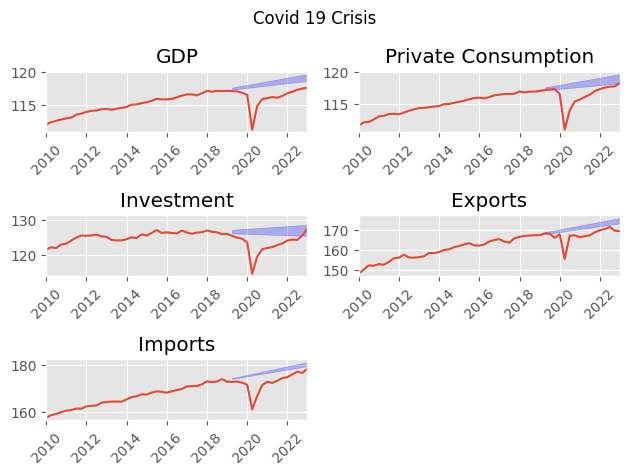

In [251]:
xmin = pd.to_datetime('2010')
xmax = pd.to_datetime('2023')
crisis = pd.to_datetime('2019Q1')

post = (df['date'] > crisis) & (df['date'] <= xmax)
focus = df[df.date >= xmin]

plt.suptitle('Covid 19 Crisis')

plt.subplot(321)
plt.plot(focus.date, focus['GDP'])
plt.fill_between(focus.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')

plt.subplot(322)
plt.plot(focus.date, focus['C'])
plt.fill_between(focus.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(focus.date, focus['I'])
plt.fill_between(focus.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(focus.date, focus['X'])
plt.fill_between(focus.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(focus.date, focus['M'])
plt.fill_between(focus.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

In [252]:
train = df.query('date <= @enddate')

arima = {}
pred = {}
conf_int = {}

arima['GDP'] = pm.auto_arima(train['GDP'], start_p=1, start_q=1, seasonal=False)
arima['C'] = pm.auto_arima(train['C'], start_p=1, start_q=1, seasonal=False)
arima['I'] = pm.auto_arima(train['I'], start_p=1, start_q=1, seasonal=False)
arima['X'] = pm.auto_arima(train['X'], start_p=1, start_q=1, seasonal=False)
arima['M'] = pm.auto_arima(train['M'], start_p=1, start_q=1, seasonal=False)

pred['GDP'], conf_int['GDP'] = get_pred_conf(arima['GDP'], 18)
pred['C'], conf_int['C'] = get_pred_conf(arima['C'], 18)
pred['I'], conf_int['I'] = get_pred_conf(arima['I'], 18)
pred['X'], conf_int['X'] = get_pred_conf(arima['X'], 18)
pred['M'], conf_int['M'] = get_pred_conf(arima['M'], 18)

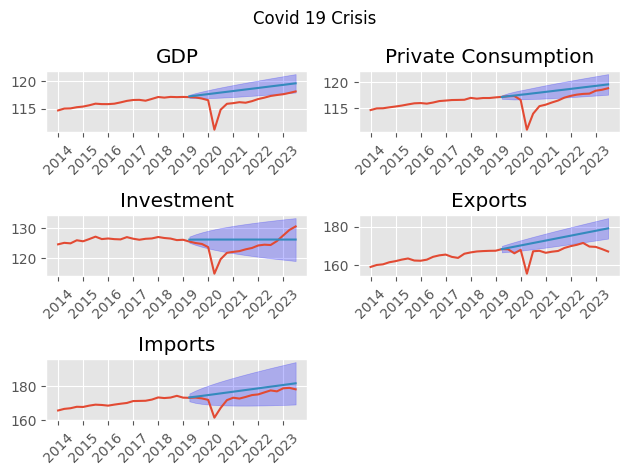

In [253]:
xrotation = 45
focus = df.query('date >= 2014')

plt.suptitle('Covid 19 Crisis')

plt.subplot(321)
plt.title('GDP')
plt.plot(focus.date, focus['GDP'])
plt.plot(focus.date[pred['GDP'].index], pred['GDP'])
plt.fill_between(focus.date[conf_int['GDP'].index], conf_int['GDP'].lower, conf_int['GDP'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(322)
plt.title('Private Consumption')
plt.plot(focus.date, focus['C'])
plt.plot(focus.date[pred['C'].index], pred['C'])
plt.fill_between(focus.date[conf_int['C'].index], conf_int['C'].lower, conf_int['C'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(323)
plt.title('Investment')
plt.plot(focus.date, focus['I'])
plt.plot(focus.date[pred['I'].index], pred['I'])
plt.fill_between(focus.date[conf_int['I'].index], conf_int['I'].lower, conf_int['I'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(324)
plt.title('Exports')
plt.plot(focus.date, focus['X'])
plt.plot(focus.date[pred['X'].index], pred['X'])
plt.fill_between(focus.date[conf_int['X'].index], conf_int['X'].lower, conf_int['X'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(325)
plt.title('Imports')
plt.plot(focus.date, focus['M'])
plt.plot(focus.date[pred['M'].index], pred['M'])
plt.fill_between(focus.date[conf_int['M'].index], conf_int['M'].lower, conf_int['M'].upper, **forecast)
plt.xticks(rotation=45)

plt.tight_layout()